# Proyecto de predicción de retrasos en vuelos comerciales

- El objetivo de este caso de estudio es proponer un enfoque para encontrar causales y estrategias para reducción o prevención en pérdidas por retrasos en los sistemas de transporte aéreo.

- Para lograr este objetivo, debemos definir el foco desde donde se hará el análisis, así como las herramientas mas adhoc para el análisis de la información.

- Se nos es dado un dataset para trabajar, por lo que tenemos algunas preguntase que quiero proponer a responder para ayudarnos a identificar el enfoque del estudio:

    Preguntas:	Cómo podemos usar esta información para identificar causas de retrasos?
                    Cuántas causas podemos identificar a partir de esta información?
                    Qué otra información podríamos integrar? deberíamos integarar más?
                    Qué enfoque se debe tomar? Delay propagation, root delay or cancellation
                    
- La información con la que contamos son 3 archivos con información de las aerolineas, aeropuertos e información de vuelos:

        Airline.csv	  =>  IATA-CODE, AIRLNE
        Airports.csv  =>  IATA_CODE, AIRPORT, CITY, STATE, COUNTRY, LATITUDE, LONGITUDEt
        Flights.csv   =>  YEAR, MONTH, DAY, DAY_OF_WEEK, AIRLINE, FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_ARIPORT,
							DESTINATION_AIRPORT, SCHEDULED_DEPARTURE, WHEELS_OFF, TAXI_OUT, DEPARTURE_TIME,
							SCHEDULED_TIME, AIR_TIME, DISTANCE, TAXI_IN, ELAPSED_TIME, SCHEDULED_ARRIVAL,
							ARRIVAL_TIME, ARRIVAL_DELAY, DIVERTED, CANCELLED, CANCELLATION_REASON,
                            AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLNE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY
                                        
- Al hacer una exploración inicial, me gustaría proponer tambien una hipótesis de las correlaciones que pudiéramos hacer de la información que tenemos:

        Hipótesis:	1. Con esta informacion podemos encontrar correlaciones entre retrasos por aerolinea
                    lo que nos podría indicar un problema en las operaciones de ciertas aerolineas
                    2. Podemos observar si hay correlaciones entre los aeropuertos de salida y destinos.
                    Nos podría indicar si hay rutas que son más problemáticas; lo que podría ser
                    consecuencia de condiciones ambientales, rutas en esas ciudades (para que llegen
                    los pasajeros al aeropuerto), ciudades más afluentes (eventos sociales), trabajos de
                    construcción en carreteras
                    3. Tiempos de retraso por aeropuerto (similar a 1) relacionado a las operaciones
                    aeroportuarias (manejo de pista, control aereo)
                    4. Razones de cancelación: buscar patrones que relacionen causas con aeropuertos, 
                    rutas, aviones, días específicos
                    5. Razones de cancelación: cancelaciones más frecuentes en ciertas épocas del año
                    o correlación con 2
                    6. En los casos de desvíos, a qué aeropuertos se reenrutan las aeronaves y desde qué
                    areopuertos (se puede mejorar esto?)

## Exploración
- Para hacer una exploración inicial de la información, usaremos algunos módulos de python para importar los datasets y hacer algunas gráficas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

airline_path = 'datasets/airlines.csv'
airport_path = 'datasets/airports.csv'
flight_path = 'datasets/flights.csv'


In [3]:
# Set data on import
def parse_if_str(s):
    try: return str(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

# def parse_ndarray(s):
#     return np.fromstring(s, sep=' ') if s else None

In [4]:
flight_df = pd.read_csv(flight_path, converters = {
    'DESTINATION_AIRPORT': parse_if_str,
    'ORIGIN_AIRPORT': parse_if_str})

In [5]:
airline_df = pd.read_csv(airline_path)
airport_df = pd.read_csv(airport_path)
flight_df = pd.read_csv(flight_path)

C:\Users\jonat\AppData\Local\Temp\ipykernel_9444\4115360430.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_df = pd.read_csv(flight_path)


## Airline dataset

In [6]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


In [7]:
airline_df.value_counts()

IATA_CODE  AIRLINE                     
AA         American Airlines Inc.          1
AS         Alaska Airlines Inc.            1
B6         JetBlue Airways                 1
DL         Delta Air Lines Inc.            1
EV         Atlantic Southeast Airlines     1
F9         Frontier Airlines Inc.          1
HA         Hawaiian Airlines Inc.          1
MQ         American Eagle Airlines Inc.    1
NK         Spirit Air Lines                1
OO         Skywest Airlines Inc.           1
UA         United Air Lines Inc.           1
US         US Airways Inc.                 1
VX         Virgin America                  1
WN         Southwest Airlines Co.          1
dtype: int64

In [8]:
airline_df.describe()

,IATA_CODE,AIRLINE
count,14,14
unique,14,14
top,UA,United Air Lines Inc.
freq,1,1


## Airport dataset

In [9]:
airport_df

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [10]:
airport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [11]:
airport_df.value_counts()

IATA_CODE  AIRPORT                                                     CITY         STATE  COUNTRY  LATITUDE  LONGITUDE 
ABE        Lehigh Valley International Airport                         Allentown    PA     USA      40.65236  -75.44040     1
MOT        Minot International Airport                                 Minot        ND     USA      48.25938  -101.28033    1
MTJ        Montrose Regional Airport                                   Montrose     CO     USA      38.50887  -107.89383    1
MSY        Louis Armstrong New Orleans International Airport           New Orleans  LA     USA      29.99339  -90.25803     1
MSP        Minneapolis-Saint Paul International Airport                Minneapolis  MN     USA      44.88055  -93.21692     1
                                                                                                                           ..
EWR        Newark Liberty International Airport                        Newark       NJ     USA      40.69250  -74.16866    

In [12]:
airport_df.describe()

,LATITUDE,LONGITUDE
count,319.000000,319.000000
mean,38.981244,-98.378964
std,8.616736,21.523492
min,13.483450,-176.646030
25%,33.652040,-110.839385
50%,39.297610,-93.403070
75%,43.154675,-82.722995
max,71.285450,-64.798560


## Flights dataset

In [1]:
pd.set_option('display.max_columns', None)
flight_df.sample(10)

NameError: name 'pd' is not defined

In [14]:
flight_df.iloc[0]

YEAR                     2015
MONTH                       1
DAY                         1
DAY_OF_WEEK                 4
AIRLINE                    AS
FLIGHT_NUMBER              98
TAIL_NUMBER            N407AS
ORIGIN_AIRPORT            ANC
DESTINATION_AIRPORT       SEA
SCHEDULED_DEPARTURE         5
DEPARTURE_TIME         2354.0
DEPARTURE_DELAY         -11.0
TAXI_OUT                 21.0
WHEELS_OFF               15.0
SCHEDULED_TIME          205.0
ELAPSED_TIME            194.0
AIR_TIME                169.0
DISTANCE                 1448
WHEELS_ON               404.0
TAXI_IN                   4.0
SCHEDULED_ARRIVAL         430
ARRIVAL_TIME            408.0
ARRIVAL_DELAY           -22.0
DIVERTED                    0
CANCELLED                   0
CANCELLATION_REASON       NaN
AIR_SYSTEM_DELAY          NaN
SECURITY_DELAY            NaN
AIRLINE_DELAY             NaN
LATE_AIRCRAFT_DELAY       NaN
WEATHER_DELAY             NaN
Name: 0, dtype: object

In [15]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [16]:
flight_df.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5819079.0,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.732926e+06,5.732926e+06,5.730032e+06,5.730032e+06,...,5.819079e+06,5.726566e+06,5.714008e+06,5.819079e+06,5.819079e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06
mean,2015.0,6.524085e+00,1.570459e+01,3.926941e+00,2.173093e+03,1.329602e+03,1.335204e+03,9.370158e+00,1.607166e+01,1.357171e+03,...,1.493808e+03,1.476491e+03,4.407057e+00,2.609863e-03,1.544643e-02,1.348057e+01,7.615387e-02,1.896955e+01,2.347284e+01,2.915290e+00
std,0.0,3.405137e+00,8.783425e+00,1.988845e+00,1.757064e+03,4.837518e+02,4.964233e+02,3.708094e+01,8.895574e+00,4.980094e+02,...,5.071647e+02,5.263197e+02,3.927130e+01,5.102012e-02,1.233201e-01,2.800368e+01,2.143460e+00,4.816164e+01,4.319702e+01,2.043334e+01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.300000e+02,9.170000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,...,1.110000e+03,1.059000e+03,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.690000e+03,1.325000e+03,1.330000e+03,-2.000000e+00,1.400000e+01,1.343000e+03,...,1.520000e+03,1.512000e+03,-5.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.230000e+03,1.730000e+03,1.740000e+03,7.000000e+00,1.900000e+01,1.754000e+03,...,1.918000e+03,1.917000e+03,8.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.900000e+01,2.900000e+01,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,...,2.400000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03


## Valores faltantes

In [17]:
flight_df.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(flight_df.isnull(), cbar=False)

In [19]:
flight_df[flight_df['TAIL_NUMBER'].isna()].sample(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2956693,2015,7,5,7,UA,267,NaN,SFO,PHL,1058,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
685490,2015,2,15,7,WN,763,NaN,DEN,LGA,1055,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
3390825,2015,7,30,4,UA,705,NaN,PBI,EWR,2005,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
1590121,2015,4,12,7,US,1861,NaN,IAH,CLT,1535,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
2764372,2015,6,23,2,UA,475,NaN,ATL,IAD,1406,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
3944862,2015,9,2,3,AA,2162,NaN,BOS,LGA,1300,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
396231,2015,1,27,2,UA,1454,NaN,LGA,IAH,630,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
492558,2015,2,2,1,UA,1146,NaN,EWR,BOS,1430,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
2859337,2015,6,29,1,UA,1279,NaN,MCO,DEN,832,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
3480697,2015,8,5,3,UA,1456,NaN,LGA,IAH,855,...,NaN,NaN,0,1,C,NaN,NaN,NaN,NaN,NaN


In [20]:
flight_df['CANCELLED'].value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

In [21]:
flight_df[flight_df['TAIL_NUMBER'].isna()]['CANCELLED'].unique()

array([1], dtype=int64)

#### Descubrimientos de los valores faltantes

1. Los valores faltantes parecen ser sistemáticos
2. Faltan los datos en los que hay cancelaciones o retrasos

### DESTINATION_AIRPORT
i.	¿Qué destinos tienen mayor cantidad de vuelos en nuestro conjunto de datos?

In [22]:
flight_df[flight_df['ARRIVAL_DELAY']>0]['DESTINATION_AIRPORT'].value_counts().head(20)

ATL    105603
ORD    104224
DFW     83312
LAX     81985
DEN     71443
SFO     55846
PHX     54619
IAH     53844
LAS     48529
MCO     41665
SEA     40434
BOS     40371
LGA     40306
MSP     39704
EWR     37316
DTW     36641
CLT     35775
JFK     33833
BWI     30101
SLC     29002
Name: DESTINATION_AIRPORT, dtype: int64

<AxesSubplot:>

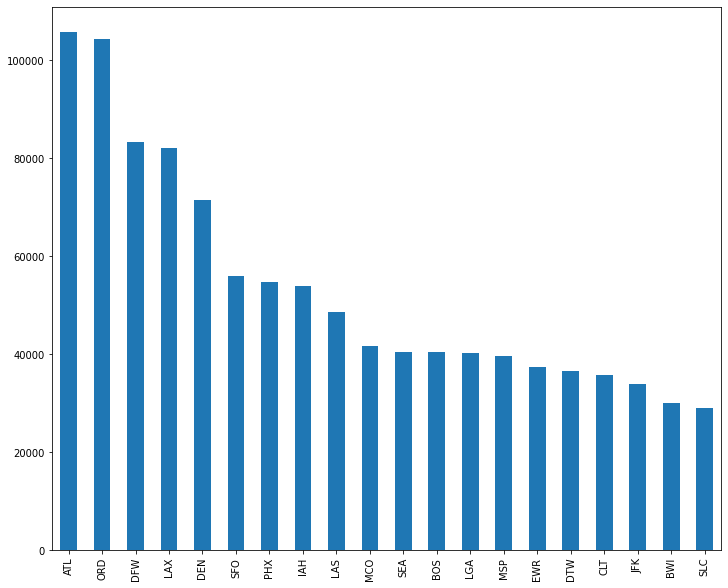

In [23]:
plt.figure(figsize=(12,10))
flight_df[flight_df['ARRIVAL_DELAY']>0]['DESTINATION_AIRPORT'].value_counts().head(20).plot.bar()

<AxesSubplot:>

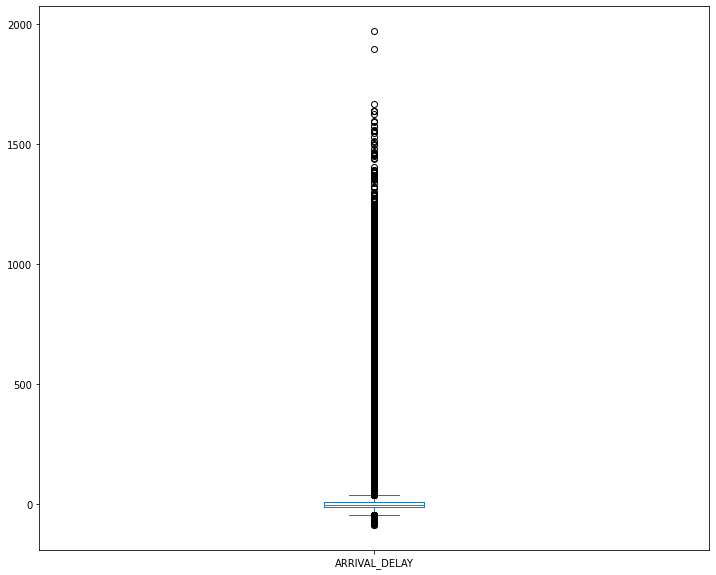

In [24]:
plt.figure(figsize=(12,10))
flight_df['ARRIVAL_DELAY'].plot(kind="box")

(-50.0, 50.0)

<Figure size 864x720 with 0 Axes>

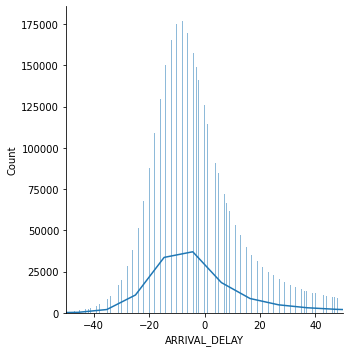

In [25]:
plt.figure(figsize=(12,10))

sns.displot(data=flight_df, x='ARRIVAL_DELAY', kde=True)

plt.xlim(-50, 50)

In [26]:
flight_df['ARRIVAL_DELAY'].describe()

count    5.714008e+06
mean     4.407057e+00
std      3.927130e+01
min     -8.700000e+01
25%     -1.300000e+01
50%     -5.000000e+00
75%      8.000000e+00
max      1.971000e+03
Name: ARRIVAL_DELAY, dtype: float64

In [27]:
max_delays = flight_df[['AIRLINE', 'ARRIVAL_DELAY']].sort_values('ARRIVAL_DELAY', ascending=False).groupby('AIRLINE')
max_delays.first()

,ARRIVAL_DELAY
AIRLINE,
AA,1971.0
AS,950.0
B6,1002.0
DL,1274.0
EV,1223.0
F9,1101.0
HA,1467.0
MQ,1528.0
NK,833.0


<AxesSubplot:xlabel='AIRLINE', ylabel='ARRIVAL_DELAY'>

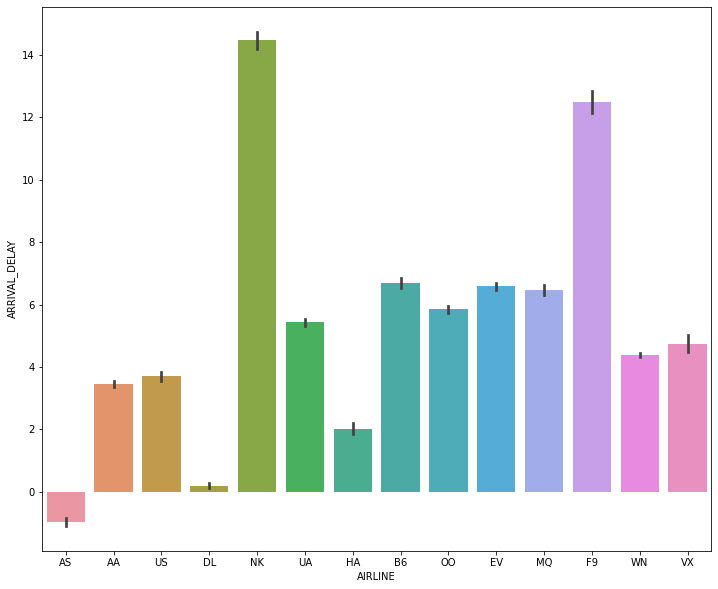

In [30]:
plt.figure(figsize=(12, 10))
sns.barplot(x='AIRLINE',y='ARRIVAL_DELAY',data=flight_df, ci=95)

In [ ]:
flight_df['CANCELLATION_REASON'].unique()

In [ ]:
flight_df.dtypes

In [ ]:
len(flight_df['FLIGHT_NUMBER'].unique())

## Inspección de los datos

- Una propuesta de inspección incial como se mencionó en la planteación de hipótesis, es comenzar a separa los parámetros que nos pueden ayudar a identificar ciertas correlaciones para diferentes segmentos

- Por ejemplo, podemos comenzar a ver la distribución de los parámetros que estána relacionados con las operaciones aeropuertarias, con el objetivo de encontrar patrones para ciertos aeropuertos(?), ciudades(?), épocas del año(?)

In [ ]:
airport_time_params = ['DEPARTURE_DELAY', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_OUT', 'TAXI_IN', 'DEPARTURE_TIME', 'ARRIVAL_DELAY']

In [ ]:
flight_df[airport_time_params].describe()

- Este grupo de datos por sí solo no nos dice mucho, pero si agrupamos con el número de vuelo para identificar la ruta (aeropuerto de origen y destino), podemos buscar distsribuciones de compotramientos por ruta por ejemplo.

In [ ]:
# Commented to save processing time
# flight_df.groupby("FLIGHT_NUMBER")[airport_time_params].describe()

In [ ]:
import matplotlib.pyplot as plt

flight_df.hist(bins=50,figsize=(20,15))
plt.show()

In [ ]:
flight_df[airport_time_params].hist(bins=50,figsize=(20,6))
plt.show()

In [ ]:
flight_df["DEPARTURE_DELAY"].describe()

In [ ]:
flight_df[flight_df["DEPARTURE_DELAY"]<250]["DEPARTURE_DELAY"].hist(bins=50,figsize=(20,6))
plt.show()

## Separando en test y entrenamiento

- Primero observaremos la variable departure_delay su distribución

In [ ]:
# flight_df["DELAY_CAT"] = pd.cut(flight_df["DEPARTURE_DELAY"], bins=[0, 7, 14, 21, 28, np.inf], labels=[1, 2, 3, 4, 5])
# flight_df["DELAY_CAT"] = pd.cut(flight_df["DEPARTURE_DELAY"], bins=50)
flight_df["DELAY_CAT"] = pd.qcut(flight_df["DEPARTURE_DELAY"], q=5, labels=[1, 2, 3, 4, 5])
flight_df["DELAY_CAT"].value_counts().sort_index().plot.bar(figsize=(8, 6))
plt.show()

- Vamos a comparar como se vería una segmentación estratificada y una aleatoria

In [ ]:
fdf = flight_df.fillna(method='ffill')

In [ ]:
fdf.head()

In [ ]:
fdf["DELAY_CAT"].fillna(method='ffill')

In [ ]:
fdf["DELAY_CAT"].isna().any()

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# Aleatorio
rand_traning, rand_testing = train_test_split(flight_df, test_size=0.2, random_state=42)

# Estratificado
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_idx, test_idx in sss.split(fdf, fdf["DELAY_CAT"]):
    strat_training = fdf.loc[train_idx]
    strat_testing = fdf.loc[test_idx]


In [ ]:
def get_proportions(ds:pd.DataFrame):
    return ds["DELAY_CAT"].value_counts().sort_index()/len(ds)

In [ ]:
# Comparacion de aleatorio contra estratificado con set de entrenamiento
total = get_proportions(fdf)
aleatorio = get_proportions(rand_traning)
estrat = get_proportions(strat_training)
pd.DataFrame({'Total': total, 'Random': aleatorio, 'Estrat': estrat,
              'Error random':100*(alearorio-total)/total,
              'Error Estrat':100*(estrat-total)/total})

In [ ]:
# Comparacion de aleatorio contra estratificado con set de prueba
total = get_proportions(fdf)
aleatorio = get_proportions(rand_testing)
estrat = get_proportions(strat_testing)
pd.DataFrame({'Total': total, 'Random': aleatorio, 'Estrat': estrat,
              'Error random':100*(alearorio-total)/total,
              'Error Estrat':100*(estrat-total)/total})

## Limpieza y exploración de los datos

- Debemos empezar a tratar de responder las preguntas en nuestras hipótesis

In [ ]:
fdf.corr()["DEPARTURE_DELAY"].sort_values(ascending=False)

In [ ]:
fdf['AIRLINE_DELAY'].plot(figsize=(8, 6))
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
scatter_matrix(flight_df[attributes], figsize=(17, 8))
plt.show()

In [ ]:
strat_training.plot(kind="scatter", x="AIRLINE_DELAY", y="WEATHER_DELAY", alpha=0.4, s=strat_training["ARRIVAL_DELAY"]/100,
               label="Arrival Delay", c="DEPARTURE_DELAY", cmap=plt.get_cmap("viridis"), colorbar=True,
               figsize=(13.33, 7.5))

plt.legend()
plt.show()